In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
import random

Lets first take a look at the images. Because the images are all separated into separate folders, we can use glob to get all the images.

In [2]:
images = glob.glob('../data/data*/CameraRGB/*.png')
masks = glob.glob('../data/data*/CameraSeg/*.png')

Here we can see the side by side of the images and masks supplied by the dataset. 

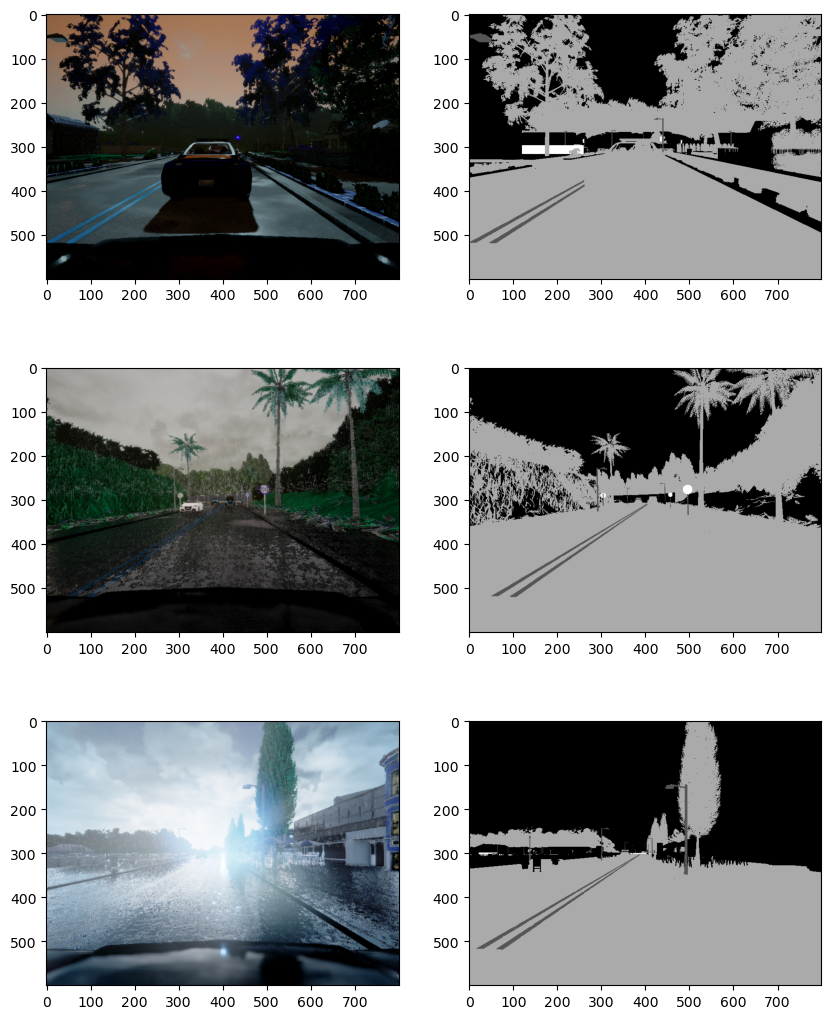

In [62]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 13))
i = 0
while i < 3:
    index = random.randrange(5000)
    ax[i][0].imshow(cv2.imread(images[index]))
    ax[i][1].imshow(cv2.imread(masks[index], cv2.IMREAD_GRAYSCALE), cmap='gray')
    i += 1

Now we will load in all the images with tensorflow and store it in a tensorflow dataset. We will create some helper functions so that they can be mapped to a tensorflow dataset

In [21]:
def get_dataset(batch_size, img_paths, mask_paths):
    def load_imgs(img_path, mask_path):
        input_img = tf_io.read_file(img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, (192,256), method='nearest')
        input_img = tf.cast(input_img, tf.float32) / 255.0

        input_mask = tf_io.read_file(mask_path)
        input_mask = tf_io.decode_png(input_mask, channels=1)
        input_mask = tf_image.resize(input_mask, (192,256), method='nearest')
        input_mask = tf_image.convert_image_dtype(input_mask, 'uint8')
        #input_mask -= 1

        return input_img, input_mask
    dataset = tf_data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(load_imgs, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

Next we'll create a U-Net model where the model first downsamples the inputs before upsampling them back for predictions. We will start off with a model that is not too complex. First we'll define some functions that will help with model creation

In [22]:
def conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.2)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    #Ensures dimension match before concatenation
    target_shape = tf.shape(x)[1:3]
    conv_features = tf.image.resize(conv_features, target_shape)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.2)(x)
    x = conv_block(x, n_filters)
    return x

Now we will create the model

In [23]:
inputs = layers.Input(shape=(192,256,3))

f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

bottleneck = conv_block(p4, 1024)

u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)

conv10 = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(u9)
outputs = layers.Conv2D(13, 1, padding='same')(conv10)

unet_model = tf.keras.Model(inputs, outputs)

Before we run the model, we will set aside a validation split

In [24]:
val_samples = 1000
random.Random(42).shuffle(images)
random.Random(42).shuffle(masks)
#train_img_paths = images[:-val_samples]
#train_mask_paths = masks[:-val_samples]
train_img_paths = images[:1000]
train_mask_paths = masks[:1000]
#val_img_paths = images[-val_samples:]
#val_mask_paths = masks[-val_samples:]
val_img_paths = images[-400:]
val_mask_paths = masks[-400:]

train_data = get_dataset(32, train_img_paths, train_mask_paths)
val_data = get_dataset(32, val_img_paths, val_mask_paths)

In [8]:
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = tf.keras.callbacks.ModelCheckpoint('oxford_segmentation.keras', save_best_only=True)

https://keras.io/examples/vision/oxford_pets_image_segmentation/
https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

With only one epoch run so that we could get a quick glance at the model performance without taking hours to run, we can see that it is not performing too well. It may do better if we let it run for more epochs, but I suspect it is because of the model structure

In [9]:
unet_model.fit(train_data, epochs=1, validation_data=val_data, callbacks=[callbacks])

32/32 [==============================] - 935s 29s/step - loss: 1.7054 - accuracy: 0.4120 - val_loss: 1.0468 - val_accuracy: 0.4235


Here we will create some functions so that we can see how the model's predicted masks compare with the validation masks

In [66]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset, num=1):
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])

While some outlines can be made out from the predicted masks, it is clear that it is doing a very poor job at capturing everything from the input image. It is far from the detail of the true mask.

1/1 [==============================] - 6s 6s/step


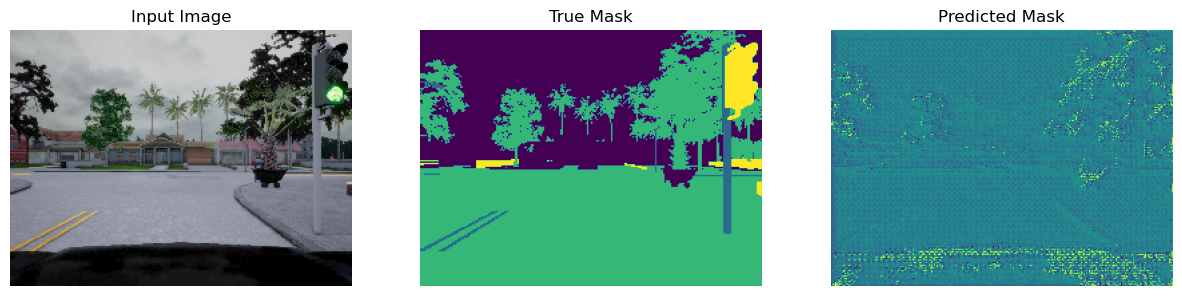

1/1 [==============================] - 7s 7s/step


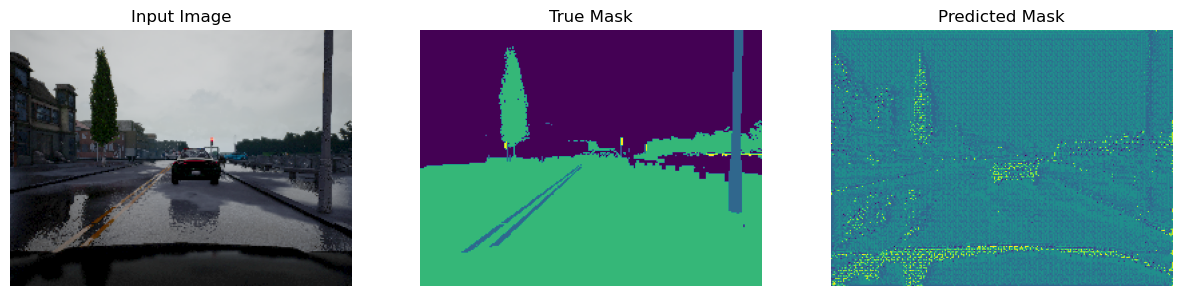

In [67]:
show_predictions(unet_model, train_data, 2)